In [1]:
# IGNORE THIS CELL WHICH CUSTOMIZES LAYOUT AND STYLING OF THE NOTEBOOK !
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore') # , category=ConvergenceWarning)
warnings.filterwarnings = lambda *a, **kw: None
from IPython.core.display import HTML; 
HTML(open("custom.html", "r").read())

# Chapter 3: Overfitting, underfitting and cross-validation

## 1. What are overfitting and underfitting ?

Let us repeat the `LogisticRegression` based beer classfier we used in the first script, we disovered that setting `C = 2` (remember that the parameter `C` controls the `regularization`, lower `C` means higher `regularization` and vice-versa) gave us good results:

In [2]:
import pandas as pd

# reading the beer dataset
beer_data = pd.read_csv("beers.csv")
print(beer_data.shape)

# all columns up to the last one:
input_features = beer_data.iloc[:, :-1]

# only the last column:
labels = beer_data.iloc[:, -1]

from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(C=2)

classifier.fit(input_features, labels)

# Predict
predicted_labels = classifier.predict(input_features)
print("{:.2f} % labeled correctly".format(sum(predicted_labels == labels) / len(labels) * 100))

(225, 5)
88.44 % labeled correctly


Here to train (fit) the model we only used 225 samples from the original data set of 300 beers.

But if the above classifier works well, it should also show the same performance on the left out 75 beers.

Let us check this on the left out data:

In [3]:
eval_data = pd.read_csv("beers_eval.csv")
print(eval_data.shape)

(75, 5)


In [4]:
eval_features = eval_data.iloc[:, :-1]
eval_labels = eval_data.iloc[:, -1]

# Predict
predicted_labels = classifier.predict(eval_features)
print("{:.2f} % labeled correctly".format(sum(predicted_labels == eval_labels) / len(eval_labels) * 100))

78.67 % labeled correctly


## WHAT HAPPENED? 
## Why is the accuracy on this data much lower?

## Answer: OVERFITTING !!

We observed a phenomenon called **"overfitting"**.


<img src="https://i.imgflip.com/2qky90.jpg" width=30% />

To explain the concept of "overfitting" we use one of the 2D data sets from script 02:

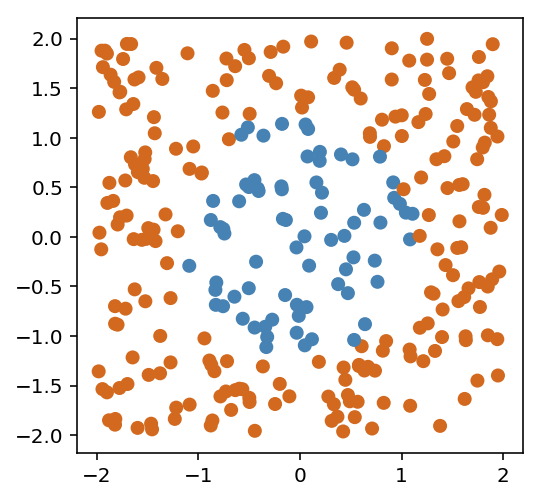

In [5]:
data = pd.read_csv("2d_points.csv")
features = data.iloc[:, :-1]
labels = data.iloc[:, -1]

COLORS = ["chocolate", "steelblue"]

plt.figure(figsize=(4, 4))
ax = plt.subplot(1, 1, 1)
plt.scatter(features.iloc[:, 0], features.iloc[:, 1], c=[COLORS[l] for l in labels], marker="o");

We mentioned before that classifiers depend on parameters (like `C`) which can be tuned to improve performance. 

Let us try to find out the purpose of the `gamma` parameter of `SVC` classifier:
(more details about the parameters of different classifiers will be introduced in script 5).

In [6]:
# code copy-pasted from script 02

import numpy as np
import matplotlib.pyplot as plt


def plot_points(features_2d, labels, plt=plt, marker='o'):
    colors = [["steelblue", "chocolate"][i] for i in labels]
    plt.scatter(features_2d[:, 0], features_2d[:, 1], color=colors, marker=marker);

    
def train_and_plot_decision_surface(
    name, classifier, features_2d, labels, preproc=None, plt=plt, marker='o', N=300
):

    features_2d = np.array(features_2d)
    
    xmin, ymin = features_2d.min(axis=0)
    xmax, ymax = features_2d.max(axis=0)

    x = np.linspace(xmin, xmax, N)
    y = np.linspace(ymin, ymax, N)
    points = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)

    if preproc is not None:
        points_for_classifier = preproc.fit_transform(points)
        features_2d = preproc.fit_transform(features_2d)
    else:
        points_for_classifier = points

    classifier.fit(features_2d, labels)
    predicted = classifier.predict(features_2d)

    if preproc is not None:
        name += " (w/ preprocessing)"
    print(name + ":\t", sum(predicted == labels), "/", len(labels), "correct")

    classes = np.array(classifier.predict(points_for_classifier), dtype=bool)
    plt.scatter(
        points[~classes][:, 0],
        points[~classes][:, 1],
        color="steelblue",
        marker=marker,
        s=1,
        alpha=0.05,
    )
    plt.scatter(
        points[classes][:, 0],
        points[classes][:, 1],
        color="chocolate",
        marker=marker,
        s=1,
        alpha=0.05,
    )

    plot_points(features_2d, labels)
    plt.title(name)

gamma = 22:	 297 / 300 correct
gamma = 12:	 298 / 300 correct
gamma = 0.1:	 296 / 300 correct


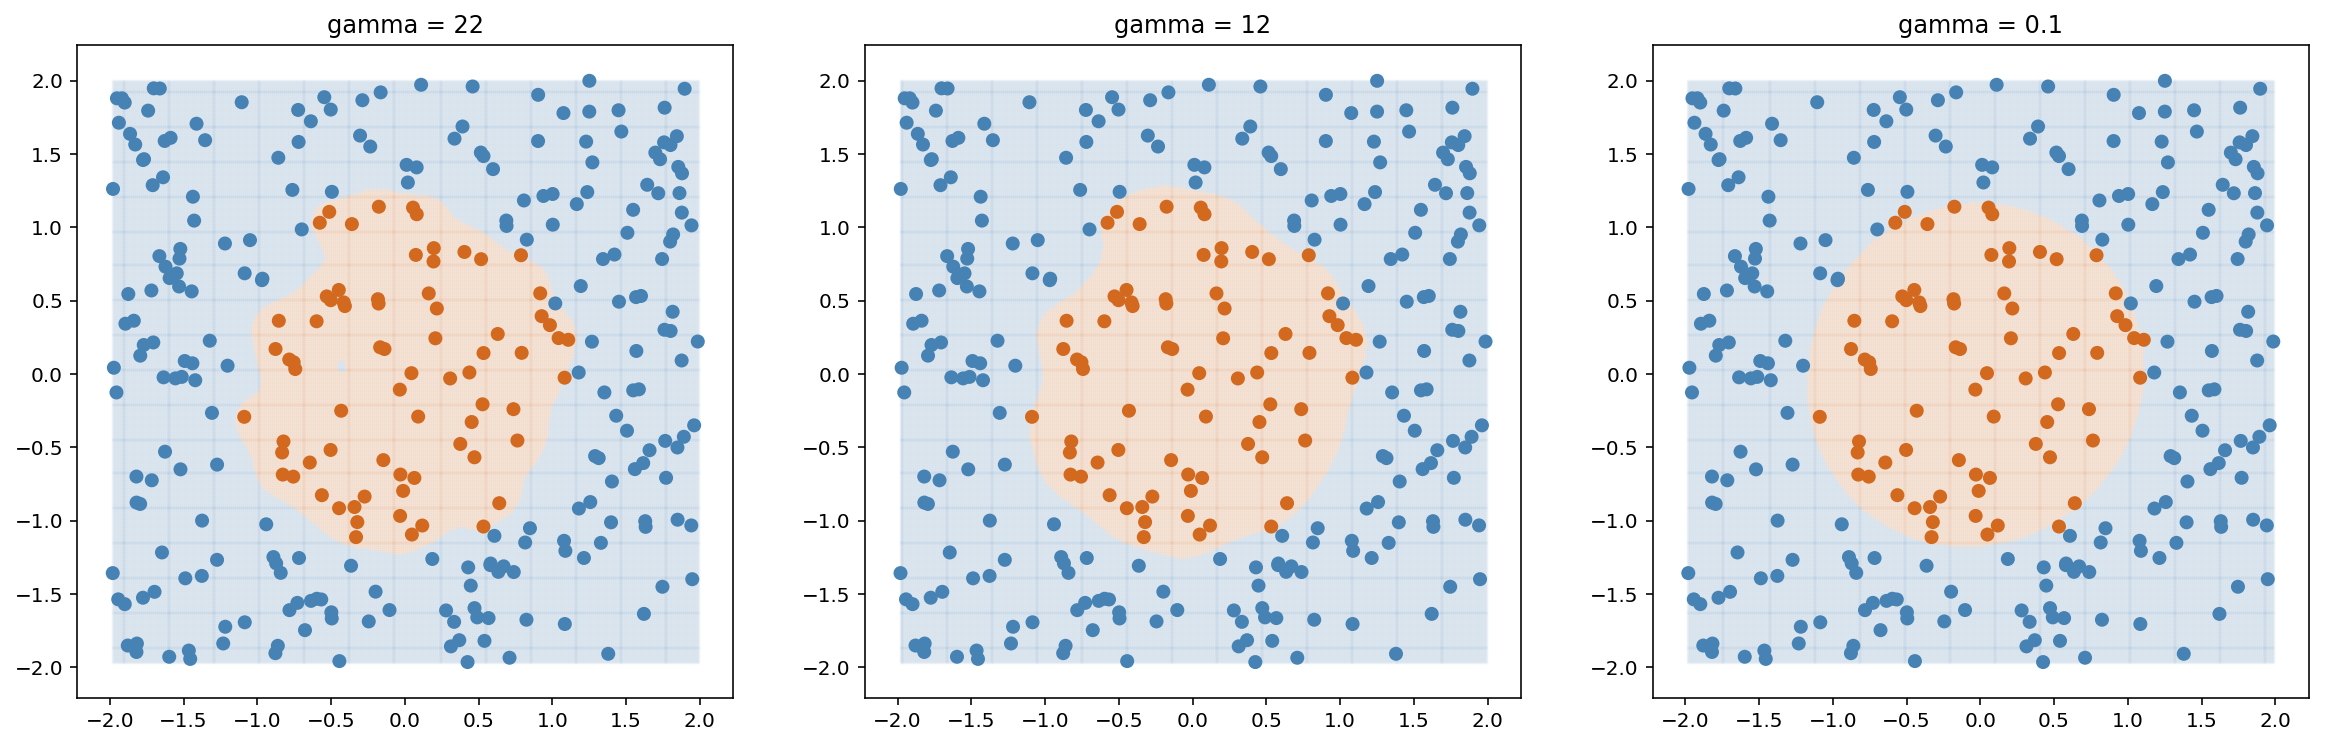

In [7]:
from sklearn.svm import SVC

df = pd.read_csv("2d_points.csv")
features = df.iloc[:, :-1]
labels = df.iloc[:, -1]

# three classifiers with different values for gamma:
classifiers = [SVC(gamma=22), 
               SVC(gamma=12), 
               SVC(gamma=.1)]

plt.figure(figsize=(20, 6));

for i, clf in enumerate(classifiers):
    
    plt.subplot(1, len(classifiers), i + 1)
    train_and_plot_decision_surface("gamma = {}".format(clf.gamma), clf, features, labels)

Observation:

The parameter `gamma` of `SVC` has an effect on the flexibility/complexity of the decision surface. A large value allows a very flexible / "irregular" decision surface, for smaller values the surface gets smoother / "stiffer" / "more regular".

This is also coined **simple** resp. **complex** models.

We see here also 

- that the smallest `gamma` value produces a classifier which seems to get the idea of a "circle", 
- whereas the large `gamma` value adapts the classifier more to the given examples.

Lets choose an even larger `gamma` value:

gamma = 80:	 300 / 300 correct


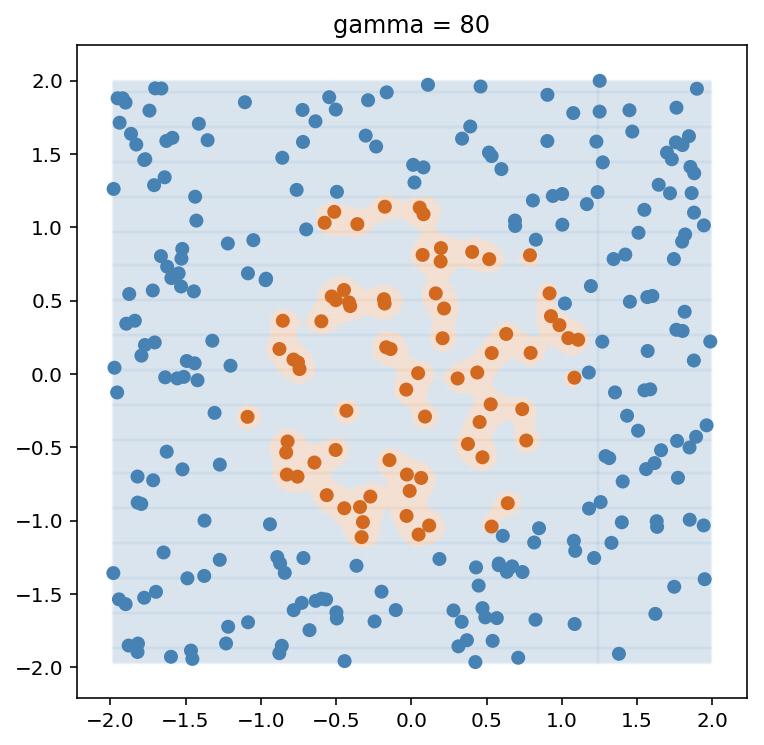

In [8]:
clf = SVC(gamma=80)
plt.figure(figsize=(6, 6));

train_and_plot_decision_surface("gamma = {}".format(clf.gamma), clf, features, labels)

The plot above shows an extreme example for the previously mentioned effect of overfitting.

- If we evaluate performance of this classifier on the training data set we get an **accuracy of `~100%`**

- But the classifier totally fails to learn the concept of a circle, and you can easily imagine how bad this  classifier performs on new and unseen data.


<div class="alert alert-block alert-warning">
<p><i class="fa fa-warning"></i>&nbsp; <strong>Definition:</strong>
<ul>

<li><strong>Overfitting:</strong>The classifier adapts/fits too closely to the sample data from a given model instead of learning the underlying concept. Thus the classifier does not generalize well and shows strongly degraded performance on previously unseen data.<br/><br/>

<li><strong>Generalization:</strong> A classifier "generalizes" well if we see similar performance on training and on new data.<br/><br/>


<li> A <strong>robust classifier:</strong> A trained classifier which is not or very little susceptible to overfitting.


</ul>


</p>
</div>




### More "probabilistic" definition:

- Our data is generated by a (usually unknown) model.
- We have only samples from this model.
- A classifier tries to approximate the underlying model based on the given samples.

In this context the observed bad generalization performance of the classifier can be explained by computing a model which is to far away from the original model.

The following graphics depicts our explanations: 

- The more "complex" a model gets the better it fits trainig data. Thus accuracy on the training data improves.
- At a certain point the model is too adapted to the training data and gets worse and worse on evaluation data.


<img src="./accuracy_training_vs_eval.svg?xxxx" width=50%/>  

## Underfitting

The other extreme is called **underfitting**: The classifiers decision boundary deviates too far from the sample data and produces a classifier which performs badly even on the training data.

We can demonstrate this by choosing a "too small" value of `gamma`

gamma = 0.062:	 276 / 300 correct


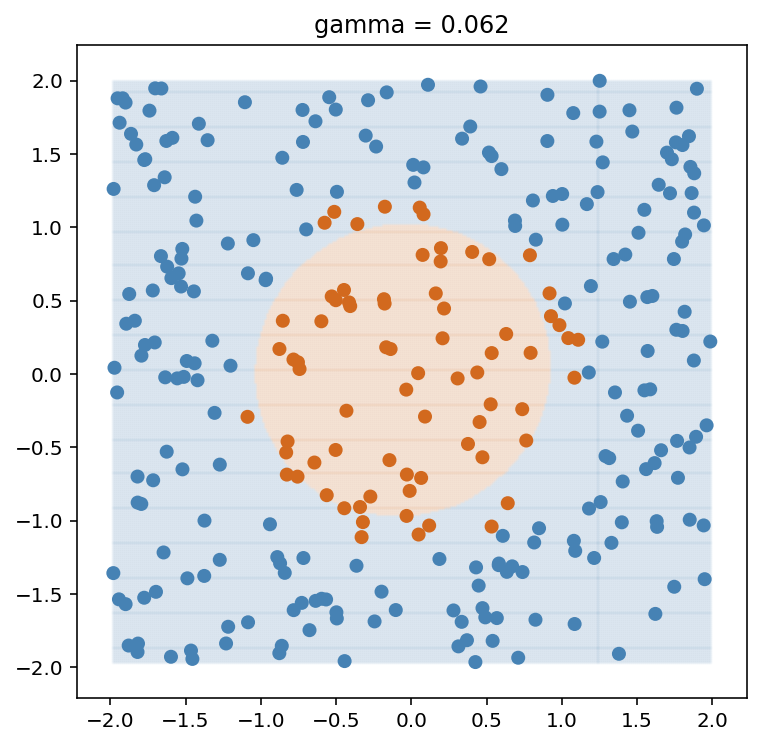

In [9]:
# small gamma tries to build a "perfect" circle

clf = SVC(gamma=.062)
plt.figure(figsize=(6, 6));

train_and_plot_decision_surface("gamma = {}".format(clf.gamma), clf, features, labels)
# plt.scatter(features.iloc[:, 0], features.iloc[:, 1], color=c, marker='.');

## How did we fall for overfitting ? 

<div class="alert alert-block alert-warning">

<h3>
    <i class="fa fa-info-circle"></i>
    <center>
Our fundamental mistake was to evaluate the performace <br/>of the classifier on the training data.

</center>
</h3>
</div>

Repeat:

<div class="alert alert-block alert-warning">

<h3>
    <i class="fa fa-info-circle"></i>
    <center>
Our fundamental mistake was to evaluate the performace <br/>of the classifier on the training data.

</center>
</h3>
</div>


## 2. How can we do better ?


There is no classifier which works out of the box in all situations. Depending on the "geometry" / "shape" of the data, classification algorithms and their settings can make a big difference.

In our previous 2D examples we were able to visualize the data and classification results, this is not possible for higher dimensional data.

The general way to handle this situation is as follows: 

- split our data into a learning data set and a test data set
- train the classifier on the learning data set
- assess performance of the classifier on the test data set.

### Variant: randomized cross validation

A randomized variant works like this:

- Perform $n$ iterations:

   - draw a fraction $p$ (e.g. 80%) from your full data set without replacement for the training data set.
   - use the remaining fraction $1 - p$ as evaluation data set
   - train classifier and compute metric(s).
  

## 3. Cross valiation with scikit-learn

In [10]:
#from sklearn.utils import shuffle
import pandas as pd

beer = pd.read_csv("beers.csv")
beer_eval = pd.read_csv("beers_eval.csv")

all_beer = pd.concat((beer, beer_eval))

all_beer.shape

(300, 5)

Below we use _accuracy_ as a so called _"metric"_, this is the percentage of correct classifications.
More about strategies on how to assess the quality of a classifier in one of the following scripts.


In [11]:
features = all_beer.iloc[:, :-1]
labels = all_beer.iloc[:, -1]
classifier = LogisticRegression(C=2)

from sklearn.model_selection import cross_val_score
# "accuracy" is the way we evaluated the classifier up to now,
# which is the percentage of correct classification.
# more about so called "metrics" in the following chapter.
scores = cross_val_score(classifier, features, labels, scoring="accuracy", cv=5)

print(scores)

[0.81967213 0.95       0.86666667 0.76666667 0.77966102]


In [12]:
m = scores.mean()
s = scores.std()

low = m - 2 * s
high = m + 2 * s

print("mean test score is {:.3f}".format(m))
print("std dev of test score is {:.3f}".format(s))
print("true test score is with 75% probability between {:.3f} and {:.3f}".format(low, high))

mean test score is 0.837
std dev of test score is 0.067
true test score is with 75% probability between 0.703 and 0.970


## Exercise section

1. Play with the previous examples.
2. Optional exercise: implement classifier + cross evaluation on the iris data set introduced in script 1.

## 4. Some reasons for overfitting and how you might fight it.

### 1. Small / insufficient data sets.

The classifier fails go "grab the concept" because the "concept" is not represented strongly enough in the data set. 

Possible solutions:

- Get more data.
- Augment your data by creating artificial/synthetic data (e.g. for images: shift / scale / rotate images) if feasible.


### 2. Unsuitbable classifier / classifier parameters used

This is what we observed in the example before.

Possible solutions:

- optimize parameters using cross-validation.

- evaluate other classification algorithms.

### 3. Noise / uninformative features

A classifier can in some sitations use noise or uninformative features to explain noise in the training data. In such cases noise contributes to "artificially" good results on the training data.

Possible solutions:

- Inspect your data to detect noisy or uninformative features.

- run experiments with excluded features. This can be automated, see [recursive feature elimination in scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE).


### 4. Strongly correlated / redundant features

In case the data set contains strongly, but not 100% correlated features, their (weighted) difference might be considered as random data. The effect is then similar to 3.

Possible solutions:

- Inspect data to detect noise and correlations.

- Use dimension reduction techniques like `PCA` (more about this later).

- Run experiments with excluded features. This can be automated, see [recursive feature elimination](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE).

The following code demonstrates the effect of noise and redundant features:

In [13]:
beer_data = pd.read_csv("beers.csv")

# all columns up to the last one:
input_features = beer_data.iloc[:, :-1]
input_labels = beer_data.iloc[:, -1]

eval_data = pd.read_csv("beers_eval.csv")

eval_features = eval_data.iloc[:, :-1]
eval_labels = eval_data.iloc[:, -1]


def assess(classifier, input_features, eval_features):

    predicted_labels = classifier.predict(input_features)
    print("{:.2f} % labeled correctly on training dataset".format(sum(predicted_labels == input_labels) / len(input_labels) * 100))

    # Predict
    predicted_labels = classifier.predict(eval_features)
    print("{:.2f} % labeled correctly on evaluation dataset".format(sum(predicted_labels == eval_labels) / len(eval_labels) * 100))

    
from sklearn.linear_model import LogisticRegression
classifier = SVC(C=2, gamma=2)

classifier.fit(input_features, input_labels)

print("ORIGINAL DATA")
assess(classifier, input_features, eval_features)

print()
print("WITH ADDED NOISY FEATURES")
np.random.seed(5)

input_features["redundant"] = input_features.loc[:, "alcohol_content"] + 1 * (np.random.random((225,)) - .5)
input_features["noise"] = .1 * (np.random.random((225,)) - .5)

eval_features["redundant"] =  eval_features.loc[:, "alcohol_content"] + 1 * (np.random.random((75,)) - .5)
eval_features["noise"] =  .1 * (np.random.random((75,)) - .5)

classifier.fit(input_features, input_labels)

assess(classifier, input_features, eval_features)

ORIGINAL DATA
98.67 % labeled correctly on training dataset
93.33 % labeled correctly on evaluation dataset

WITH ADDED NOISY FEATURES
99.11 % labeled correctly on training dataset
89.33 % labeled correctly on evaluation dataset


You can see above that the classifier yields better accuracy on the extended training data set. But you also can see that the performance on the extended evaluation data set is worse than before.



## 5. Training the final classifier

Cross-validation was helpful to determine and tune a good classifier. But how do we eventually build the classifier we want to use later "in production" ?

A common procedure is:

- Split your data 80% to 20% (or another fraction) from the beginning.


- Use the 80% fraction for determining and tuning a classifier.


- Train the final classifier on the 80% part.


- Finally use the 20% fraction for a final validation of the classifiers accuracy.

<img src="./cross_eval_and_test.svg?7">

Comment: Literature is not consistent in terms. Sometimes the terms "validation data set" and "test data set" are interchanged.

### Demonstration

We introduce the `train_test_split` function from `sklearn.model_selection` in the following example.

It splits features and labels in a given proportion. Usually this is randomized, so that you get different results for every function invocation. To get the same result every time we use `random_state=..` (with arbitrary number)
below:

In [14]:
# SPLIT DATASETS 80:20

np.random.seed(5)  # to get same results every time

n = len(features)
indices = np.arange(n)
np.random.shuffle(indices)

features = features.iloc[indices]
labels = labels.iloc[indices]

from sklearn.model_selection import train_test_split

# split 80:20 with fixed randomization:
(features_crosseval, 
 features_validation, 
 labels_crosseval, 
 labels_validation) = train_test_split(features, labels, test_size=0.2, random_state=42)

In [15]:
# FIND A "BEST" CLASSIFIER
 
results = []

print("OPTIMIZE SETTINGS")

for C in (1, 2, 4):
    for gamma in (.1, 1, 2, 4):
        classifier = SVC(C=C, gamma=gamma)
        test_scores = cross_val_score(classifier, features_crosseval, labels_crosseval, scoring="accuracy", cv=5)
        print("score = {:.3f}  C={:.1f}  gamma={:.1f}".format(test_scores.mean(), C, gamma))
        results.append((test_scores.mean(), C, gamma))
        
# max of list of tuples considers value of first entry
# to compare tuples. This we look for test_scores.mean() value:

best_result = max(results)
best_score, C, gamma = best_result

print()
print("BEST RESULT CROSS VALIDATION")
print("score = {:.3f}  C={:.1f}  gamma={:.1f}".format(best_score, C, gamma))

OPTIMIZE SETTINGS
score = 0.830  C=1.0  gamma=0.1
score = 0.900  C=1.0  gamma=1.0
score = 0.887  C=1.0  gamma=2.0
score = 0.888  C=1.0  gamma=4.0
score = 0.913  C=2.0  gamma=0.1
score = 0.913  C=2.0  gamma=1.0
score = 0.913  C=2.0  gamma=2.0
score = 0.884  C=2.0  gamma=4.0
score = 0.934  C=4.0  gamma=0.1
score = 0.933  C=4.0  gamma=1.0
score = 0.921  C=4.0  gamma=2.0
score = 0.921  C=4.0  gamma=4.0

BEST RESULT CROSS VALIDATION
score = 0.934  C=4.0  gamma=0.1


In [16]:
# EVALUATE CLASSIFIER ON VALIDATION DATASET

classifier = SVC(C=C, gamma=gamma)

classifier.fit(features_crosseval, labels_crosseval)
predicted = classifier.predict(features_validation)

final_accuracy = sum(predicted == labels_validation) / len(labels_validation)

print("VALIDATION")
print("score = {:.3f}".format(final_accuracy))

VALIDATION
score = 0.983


## Exercise section 

1. Run the previous examples. Also change value for `cv` to `4`.

2. Can you determine a better pair of `C` and `gamma` ?

In [17]:
results = []

print("OPTIMIZE SETTINGS")

for C in (5, 10):
    for gamma in (.5, 1, 2):
        classifier = SVC(C=C, gamma=gamma)
        test_scores = cross_val_score(classifier, features_crosseval, labels_crosseval, scoring="accuracy", cv=5)
        print("score = {:.3f}  C={:.1f}  gamma={:.1f}".format(test_scores.mean(), C, gamma))
        results.append((test_scores.mean(), C, gamma))
        
# max of list of tuples considers value of first entry
# to compare tuples. This we look for test_scores.mean() value:

best_result = max(results)
best_score, C, gamma = best_result

print()
print("BEST RESULT CROSS VALIDATION")
print("score = {:.3f}  C={:.1f}  gamma={:.1f}".format(best_score, C, gamma))

# EVALUATE CLASSIFIER ON VALIDATION DATASET

classifier = SVC(C=C, gamma=gamma)

classifier.fit(features_crosseval, labels_crosseval)
predicted = classifier.predict(features_validation)

final_accuracy = sum(predicted == labels_validation) / len(labels_validation)

print("VALIDATION")
print("score = {:.3f}".format(final_accuracy))

OPTIMIZE SETTINGS
score = 0.937  C=5.0  gamma=0.5
score = 0.934  C=5.0  gamma=1.0
score = 0.929  C=5.0  gamma=2.0
score = 0.933  C=10.0  gamma=0.5
score = 0.938  C=10.0  gamma=1.0
score = 0.921  C=10.0  gamma=2.0

BEST RESULT CROSS VALIDATION
score = 0.938  C=10.0  gamma=1.0
VALIDATION
score = 1.000


<div class="alert alert-block alert-info">
<p><i class="fa fa-warning"></i>&nbsp; Recommendation
    
The result of crossvalidation depends on the order of the data set, the validation data set and the setting of `cv`. 

As a consequence we might find different optimal settings for a classifier.

So don't try to squeeze out minimal performance improvements !

</div>

### Optional exercises

1. Play with `LogisticRegression` classifier.

2. Optional exercise: implement same strategy for the iris data set introduced in script 1.

In [18]:
from sklearn.linear_model import LogisticRegression
 
results = []

print("OPTIMIZE SETTINGS")

for penalty in ("l1", "l2"):
    for C in (1, 2, 5, 10):
        classifier = LogisticRegression(penalty=penalty, C=C)
        test_scores = cross_val_score(classifier, features_crosseval, labels_crosseval, scoring="accuracy", cv=5)
        print("score = {:.3f}  C={:.1f}  gamma={:.1f}".format(test_scores.mean(), C, gamma))
        results.append((test_scores.mean(), C, gamma))
        
# max of list of tuples considers value of first entry
# to compare tuples. This we look for test_scores.mean() value:

best_result = max(results)
best_score, C, gamma = best_result

print()
print("BEST RESULT CROSS VALIDATION")
print("score = {:.3f}  C={:.1f}  gamma={:.1f}".format(best_score, C, gamma))

OPTIMIZE SETTINGS
score = 0.908  C=1.0  gamma=1.0
score = 0.899  C=2.0  gamma=1.0
score = 0.912  C=5.0  gamma=1.0
score = 0.912  C=10.0  gamma=1.0
score = 0.792  C=1.0  gamma=1.0
score = 0.842  C=2.0  gamma=1.0
score = 0.887  C=5.0  gamma=1.0
score = 0.895  C=10.0  gamma=1.0

BEST RESULT CROSS VALIDATION
score = 0.912  C=10.0  gamma=1.0


In [19]:
from sklearn.datasets import load_iris

data = load_iris()

df = pd.DataFrame(data.data, columns=data.feature_names)
df["class"] = data.target

features = df.iloc[:, :-1]
labels = df.iloc[:, -1]

results = []

print("OPTIMIZE SETTINGS")

for C in (1, 2, 5, 10):
    for gamma in (.5, 1, 2):
        classifier = SVC(C=C, gamma=gamma)
        test_scores = cross_val_score(classifier, features, labels, scoring="accuracy", cv=5)
        print("score = {:.3f}  C={:.1f}  gamma={:.1f}".format(test_scores.mean(), C, gamma))
        results.append((test_scores.mean(), C, gamma))
        
# max of list of tuples considers value of first entry
# to compare tuples. This we look for test_scores.mean() value:

best_result = max(results)
best_score, C, gamma = best_result

print()
print("BEST RESULT CROSS VALIDATION")
print("score = {:.3f}  C={:.1f}  gamma={:.1f}".format(best_score, C, gamma))

OPTIMIZE SETTINGS
score = 0.980  C=1.0  gamma=0.5
score = 0.967  C=1.0  gamma=1.0
score = 0.967  C=1.0  gamma=2.0
score = 0.973  C=2.0  gamma=0.5
score = 0.973  C=2.0  gamma=1.0
score = 0.967  C=2.0  gamma=2.0
score = 0.973  C=5.0  gamma=0.5
score = 0.960  C=5.0  gamma=1.0
score = 0.960  C=5.0  gamma=2.0
score = 0.967  C=10.0  gamma=0.5
score = 0.953  C=10.0  gamma=1.0
score = 0.960  C=10.0  gamma=2.0

BEST RESULT CROSS VALIDATION
score = 0.980  C=1.0  gamma=0.5
